## Importing Necessary Libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import layoutparser as lp
import cv2

import pickle

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [25]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [26]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Document Region of Interest & Text Extraction 

Any Document be it scanned image or text document has it's own distinct layout and structure. As of now, in the [other classification models](EfficientNet-4Piece-Model-Embed-Visualization.ipynb#T-SNE) we saw how they captured some of these visual features for some of the document classes and clustered them out well. But these models face a tough situation with most of the other classes. So, a good idea would be to guide the CNN based visual models to focus on particular parts of the document well and learn their patterns. That is what we are interested in doing. We will preprocess the training and validation set to put the extra information about the document layout to help in classification. 

Loading the pre-trained Document Layout Analysis.

In [4]:
model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"})

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng')

Visualization of the Layout Partitioned Documents. We use the OCR engine on these extracted RoIs to extract the textual component of the documents.

/Users/rishideychowdhury/Desktop/Document-Classification/env/lib/python3.8/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


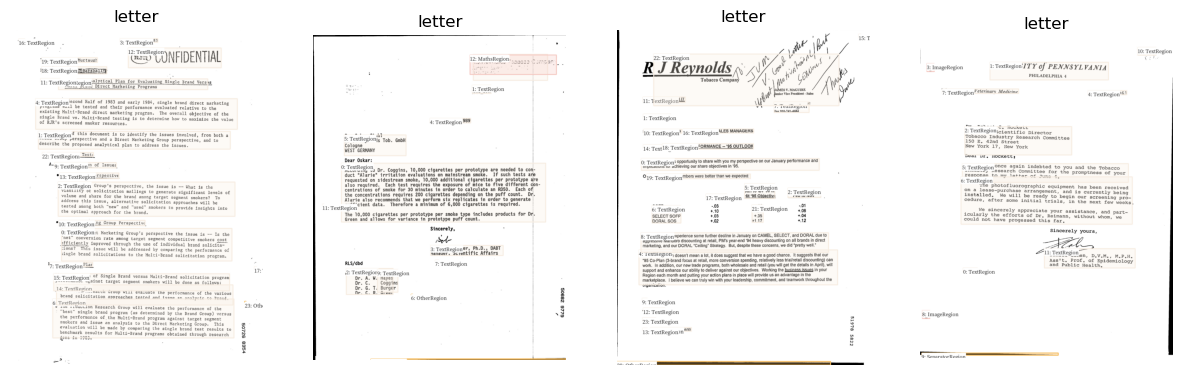

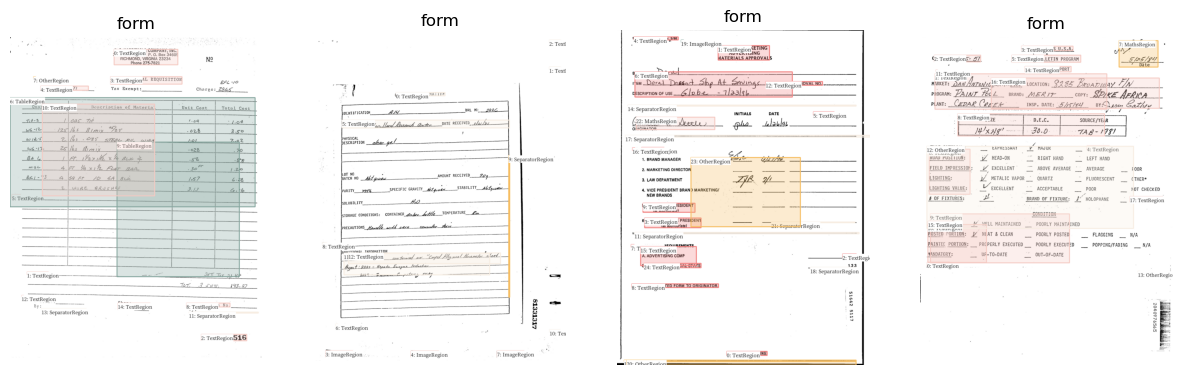

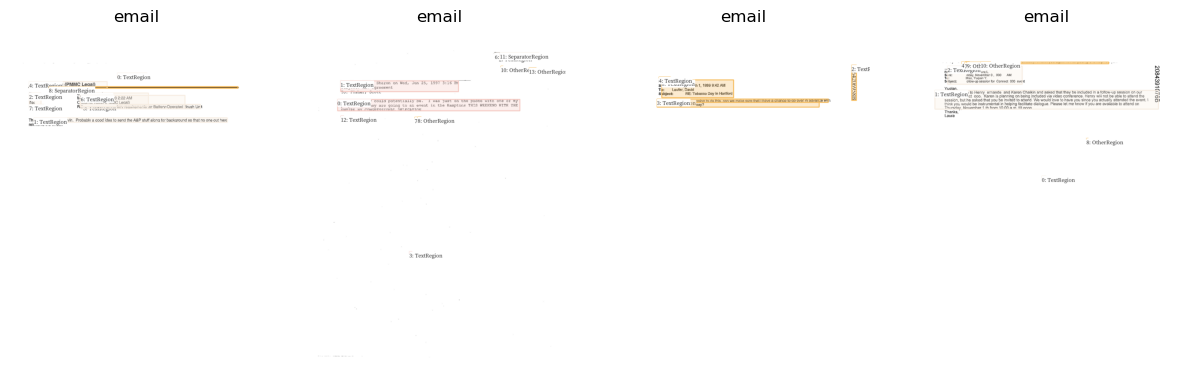

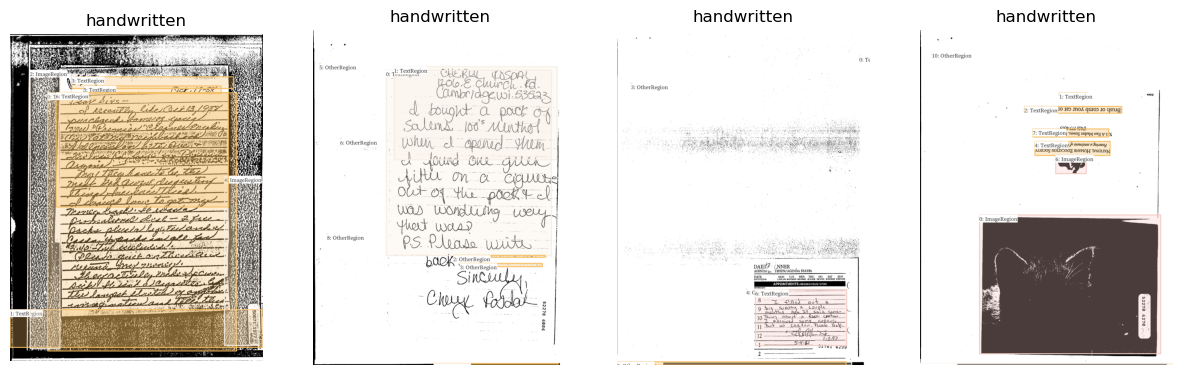

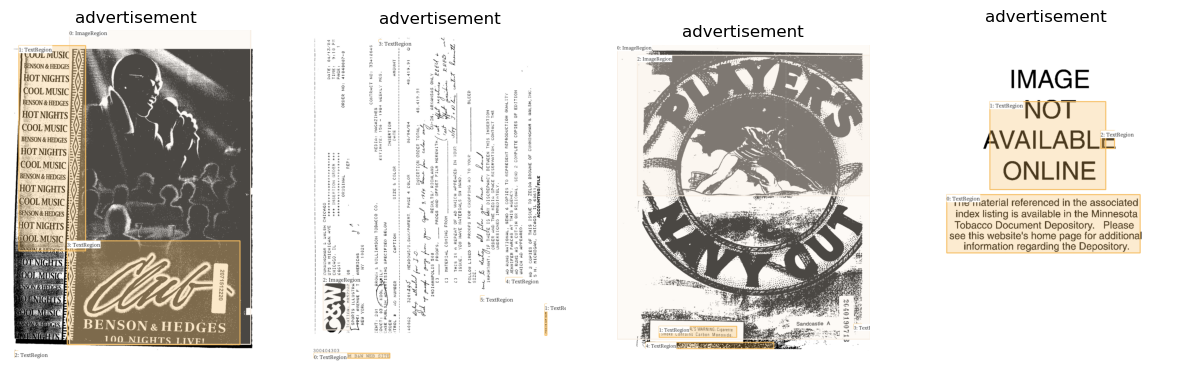

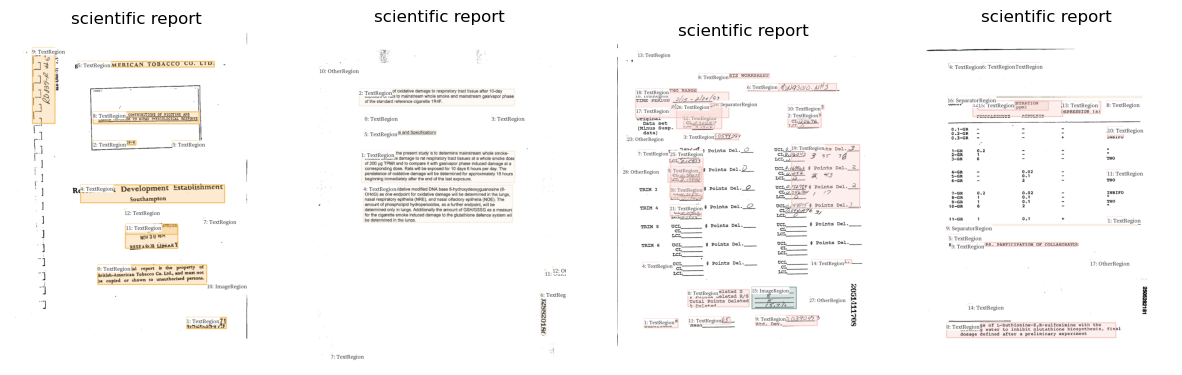

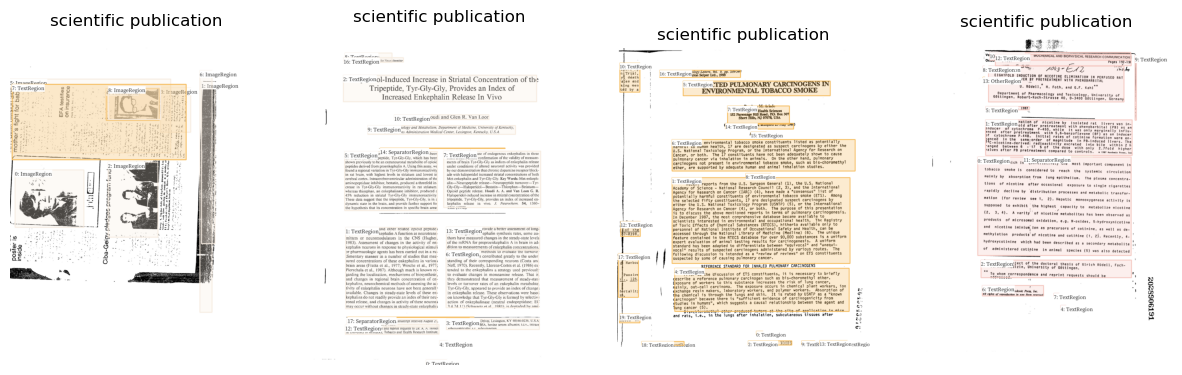

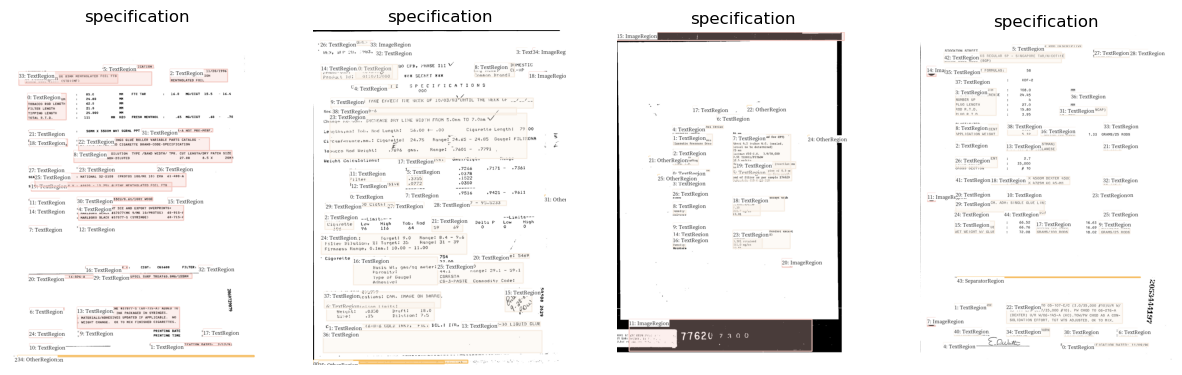

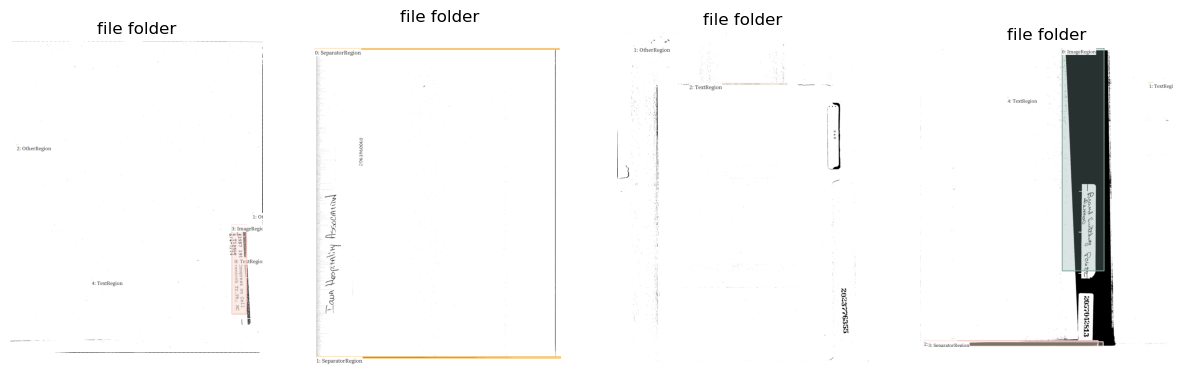

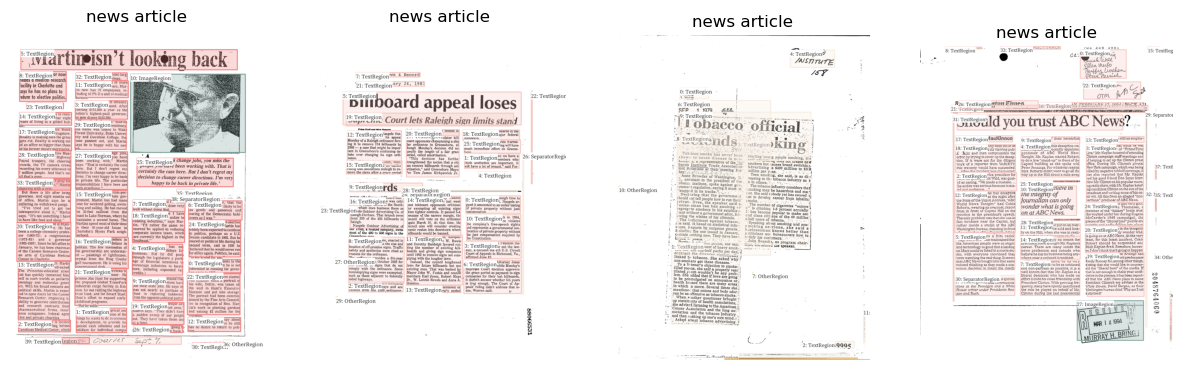

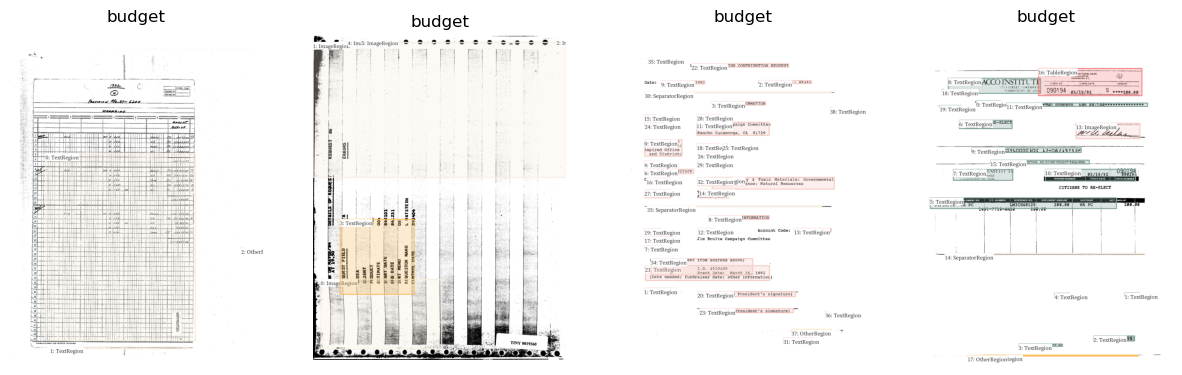

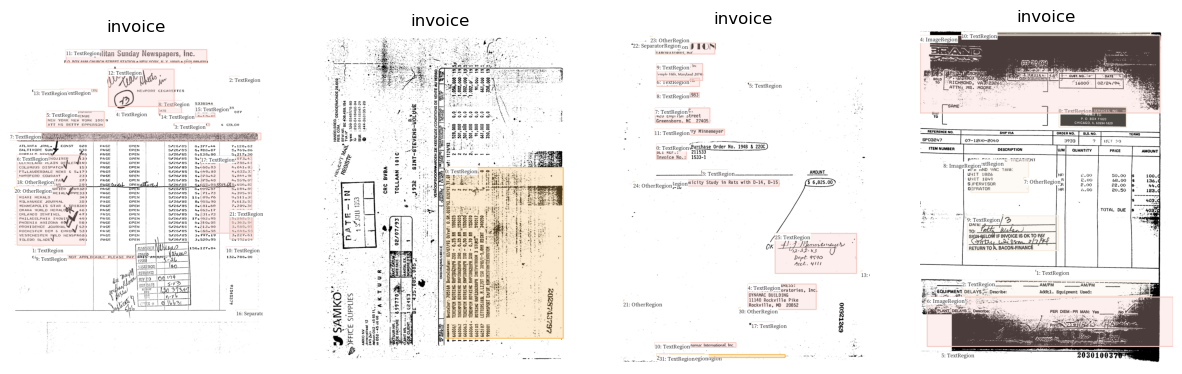

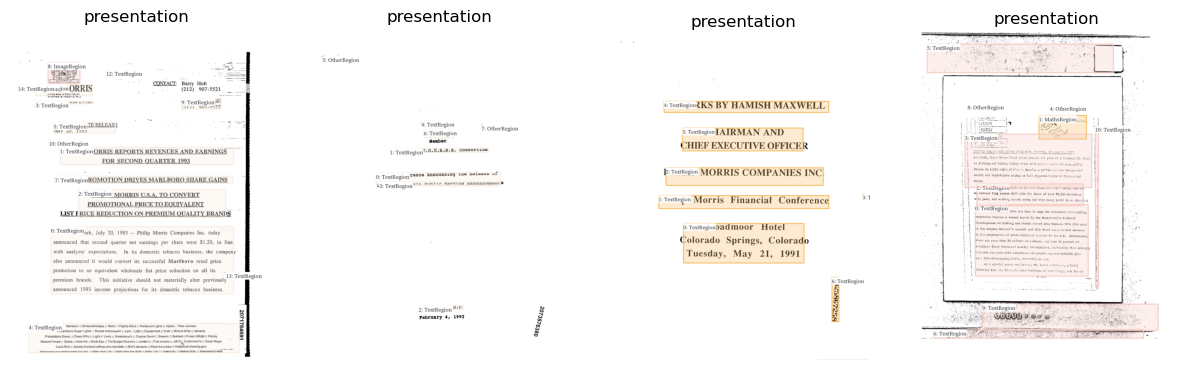

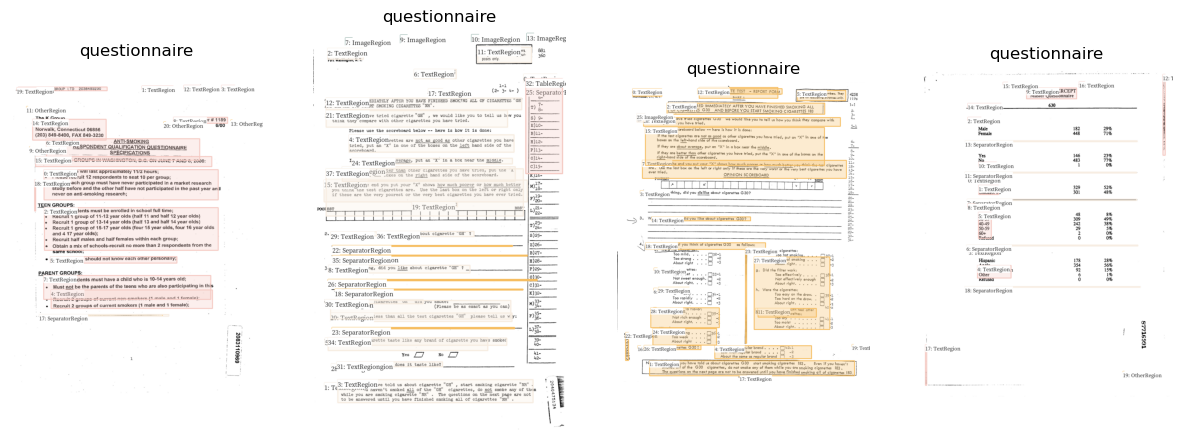

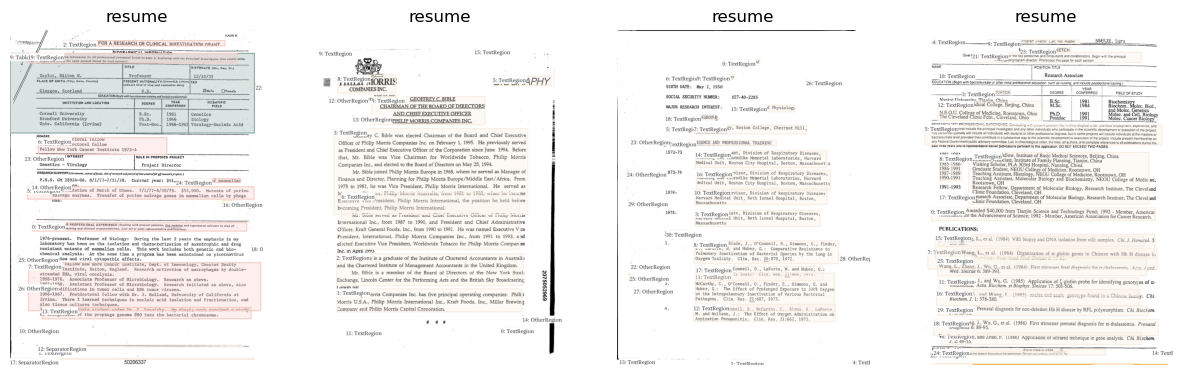

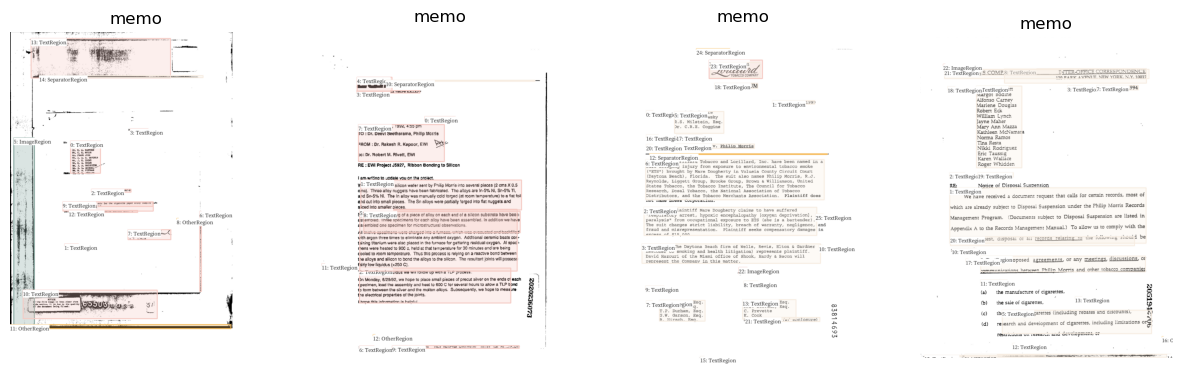

In [116]:
for i in range(len(class_labels)):
    fig, ax = plt.subplots(1, 4, figsize=(15, 30))
    imgs = [cv2.imread(name)[..., ::-1] for name in list(labels[labels.label == i][:4]['images'])]
    layouts = [model.detect(img) for img in imgs]
    img_arrs = [np.array(lp.draw_box(img, lay, box_width=3, show_element_type=True, show_element_id=True, box_alpha=0.3)) for img, lay in zip(imgs, layouts)]
    m = 0
    for k in range(4):
        ax[k].imshow(img_arrs[m])
        ax[k].axis('off')
        ax[k].set_title(class_names[i])
        m += 1

Below, we see the example of a training set image being passed through a pipeline of steps to extract all the raw information(needs further cleaning and pre-processing) available from the document image.

In [76]:
image = cv2.imread('./Data/train/train/121.tif')
layout = model.detect(image)

Original Image

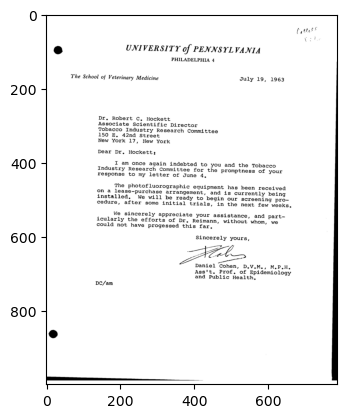

In [81]:
plt.imshow(image)

Region of Interest extracted Image.

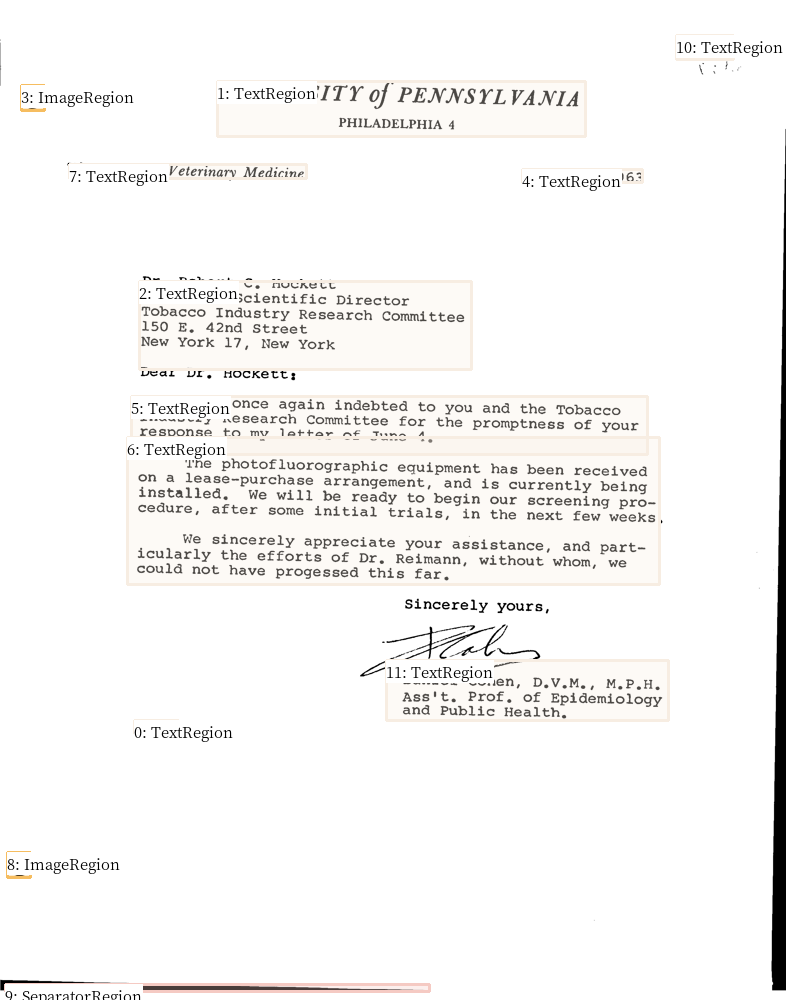

In [77]:
lp.draw_box(image, layout, box_width=3, show_element_type=True, show_element_id=True, box_alpha=0.3)

In [78]:
for block in layout:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

Optical Character Recognized output from the RoIs.

In [79]:
for txt in layout.get_texts():
    print(txt, end='\n---\n')

DC/am

---
UNI VERSITY of PENNSYL VANIA

PHILADELPHIA 4

---
or. Robert C, Hockett

Associate Scientific Director
Tobacco Industry Research Committee
150 E, 42nd Street

New York 17, New York

Deere De meen

---

---
July 19, 1963

---
I am once again indebted to you and the Tobacco
Industry Research Committee for the promptness of your
response to my letter of June 4,

---
OSE EES EE OSE RAEURMREL OF June 4,

The photofluorographic equipment has been received
on a lease-purchase arrangement, and is currently being
installed, We will be ready to begin our screening pro-
cedure, after some initial trials, in the next few weeks,

We sincerely appreciate your assistance, and part-
icularly the efforts of Dr. Reimann, without whom, we
could not have progessed this far.

---
The School of Veterinary Medicine

---

---

---
(thet

---
—— —
Daniel Cohen, D.V.M., M.P.H.
Ass't. Prof, of Epidemiology
and Public Health,

---


### Train Data Pre-Processing

Pre-processing the entire training dataset to be used while training later.

The format followed to save the extracted information per document image is as follows:
- The list of doc_rois is arranged in increasing order from 0.tif to 15999.tif in the training set.
- Each element of the list (i.e. corresponding to each image) is a list of length $4$.
- First element being the coordinates of (top-left and bottom-right) of each RoI found in this document image.
- Second element being the types of each RoIs found i.e. text, image, separator, etc.
- Third being the exact extracts of the RoIs, cropped from the original image
- Fourth being the OCR output for each RoI.

$20+$ instances(depending on RAM) of the following code can be run at once to speed up the conversion. Don't forget the change the starting point else each instance will be generating info for the same image over and over again. 

In [ ]:
doc_rois = list()
k = 1
for idx, image in enumerate(labels['images']):
    img = cv2.imread(image)
    layout = model.detect(img)
    roi_imgs = list()
    roi_coords = list()
    roi_texts = list()
    roi_types = list()
    for block in layout:
        segment_image = (block
                           .pad(left=5, right=5, top=5, bottom=5)
                           .crop_image(img))
        roi_imgs.append(segment_image)
        text = ocr_agent.detect(segment_image)
        roi_texts.append(text)
        block.set(text=text, inplace=True)
        roi_coords.append(block.coordinates)
        roi_types.append(block.type)
    doc_rois.append([roi_coords, roi_types, roi_imgs, roi_texts])
    if (idx + 1) % 100 == 0:
        with open(f'./Data/ROI-Extractions/train/{k}.pkl', 'wb') as f:
            pickle.dump(doc_rois, f)
        k += 1
        doc_rois = list()

### Validation Data Pre-Processing

We pre-process the validation set images similarly as above.

In [ ]:
valid_image_ids = list(range(17801, 18701))
valid_image_paths = ['./Data/validation/validation/'+str(id)+'.tif' for id in valid_image_ids]

In [ ]:
doc_rois = list()
k = 1
for idx, image in enumerate(valid_image_paths):
    img = cv2.imread(image)
    layout = model.detect(img)
    roi_imgs = list()
    roi_coords = list()
    roi_texts = list()
    roi_types = list()
    for block in layout:
        segment_image = (block
                           .pad(left=5, right=5, top=5, bottom=5)
                           .crop_image(img))
        roi_imgs.append(segment_image)
        text = ocr_agent.detect(segment_image)
        roi_texts.append(text)
        block.set(text=text, inplace=True)
        roi_coords.append(block.coordinates)
        roi_types.append(block.type)
    doc_rois.append([roi_coords, roi_types, roi_imgs, roi_texts])
    if (idx + 1) % 100 == 0:
        with open(f'./Data/ROI-Extractions/validation/{k}.pkl', 'wb') as f:
            pickle.dump(doc_rois, f)
        k += 1
        doc_rois = list()